In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [7]:
class MotionPlanning(Drone):

    def __init__(self, connection, global_goal=None, local_goal=None, grid_goal=None, waypoints=[]):
        super().__init__(connection)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        # To start an instance with pre-calculated WPs
        if waypoints is not None and len(waypoints) > 0:
            self.waypoints = waypoints
        self.in_mission = True
        self.check_state = {}
        
        self.takeoff_counter = 0
        self.timeout = connection._timeout
        self.is_timeout = False

        self.global_goal = global_goal
        self.local_goal = local_goal
        self.grid_goal = grid_goal
        # initial state
        self.flight_state = States.MANUAL

        # register all your callbacks here
        self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
        self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
        self.register_callback(MsgID.STATE, self.state_callback)

    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
            else:
                # Try to recover if stuck in TAKEOFF
                self.takeoff_counter += 1
                if self.takeoff_counter == 1000:
                    self.landing_transition()
                    self.disarming_transition()
                    self.manual_transition()
                    self.stop()                    
                    print("RESETING")
                if (self.takeoff_counter + 1)% 100 == 0:
                    print("reset states, current h:%s, tc:%s" %( self.local_position[2], self.takeoff_counter))
                    lsw = len(self.waypoints)
                    if (lsw > 1):
                        self.waypoints = self.waypoints[:lsw - 1]
                    self.flight_state = States.MANUAL                
        elif self.flight_state == States.WAYPOINT:
            if -1.0 * self.local_position[2] < 0.5 * self.target_position[2]:
                # Try to recover if stuck 
                self.takeoff_transition()
                print("still in landing position turn back to takeoff")
            dist_to_wp = np.linalg.norm(self.target_position[0:2] - self.local_position[0:2])
            if dist_to_wp < 2.0:
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                elif (dist_to_wp < 1.0):
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self.in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    
                    self.plan_path()
                    
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        self.target_position = self.waypoints.pop(0)
        print('target position', self.target_position)
        self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self.in_mission = False

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        pass

    def start(self):
        self.start_log("Logs", "NavLog.txt")

        print("starting connection")
        self.connection.start()

        # Only required if they do threaded
        # while self.in_mission:
        #    pass

        self.stop_log()
        
    def local_to_grid(self, north_offset, east_offset):
        if len(self.local_goal) == 2:
            ng, eg = self.local_goal
        elif len(self.local_goal) == 3:
            ng, eg, ag = self.local_goal
        self.grid_goal = grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
    
    def global_to_grid(self, north_offset, east_offset):
        self.local_goal = global_to_local(self.global_goal, global_home=self.global_home)
        self.local_to_grid(north_offset, east_offset)
    
    def place_goal_in_grid(self, grid_shape):
        grid_goal = self.grid_goal
        if grid_goal[0] > grid_shape[0] - 2:
            grid_goal = (grid_shape[0] - 2, grid_goal[1])
        elif grid_goal[0] < 1:
            grid_goal = (1, grid_goal[1])            
        if grid_goal[1] > grid_shape[1] - 2:
            grid_goal = (grid_goal[0], grid_shape[1] - 2)
        elif grid_goal[1] < 1:
            grid_goal = (grid_goal[0], 1)  
        self.grid_goal = grid_goal

In [8]:
def main(drn=None, global_goal=None, local_goal=None, grid_goal=None):
    print("main")
    #parser = argparse.ArgumentParser()
    #parser.add_argument('--port', type=int, default=5760, help='Port number')
    #parser.add_argument('--host', type=str, default='127.0.0.1', help="host address, i.e. '127.0.0.1'")
    #args = parser.parse_args()
    timeout = 60
    try_count = 3
    try_i = 0
    is_timeout = True
    waypoints = None
    t0 = time.time()
    
    # If there is a timeout with a drone instance,
    # the instance terminates itself
    # main will transfer the WPs to a new instance    
    while (is_timeout and try_i < try_count):
        conn = MavlinkConnection('tcp:{0}:{1}'.format('127.0.0.1', 5760), timeout=timeout)
        drone = MotionPlanning(conn,
                               global_goal=global_goal,
                               local_goal=local_goal,
                               grid_goal=grid_goal,
                              waypoints=waypoints)
        time.sleep(1)
        drone.start()
        try_i += 1
        print("%s. is_timeout:%s, state:%s, connected:%s, in_mission:%s, armed:%s, t:%s" %(
        try_i, drone.is_timeout, drone.flight_state, drone.connected, drone.in_mission, drone.armed, time.time() - t0))
        is_timeout = drone.is_timeout
        waypoints = drone.waypoints

In [9]:
def plot(grid, start_ne, goal_ne, goal_list=None, path=None):
    plt.figure(figsize=(24, 12))
    plt.imshow(grid, cmap='Greys', origin='lower')
    
    # For the purposes of the visual the east coordinate lay along
    # the x-axis and the north coordinates long the y-axis.
    plt.plot(start_ne[1], start_ne[0], 'gx', markersize=5, markeredgewidth=5)
    plt.plot(goal_ne[1], goal_ne[0], 'rx', markersize=5, markeredgewidth=5)
    
    for g in goal_list:
        plt.plot(g[1], g[0], 'bo', markeredgewidth=2)

    if path is not None:
        pp = np.array(path)
        plt.plot(pp[:, 1], pp[:, 0], 'g')

    plt.xlabel('EAST')
    plt.ylabel('NORTH')
    plt.show()    

In [10]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

def prune_path(path, max_p=50):
    pruned_path = [p for p in path]
    # prune the path!
    i = 0
    ri = 0
    while i < len(pruned_path) - 2:
        p1 = point(pruned_path[i])
        p2 = point(pruned_path[i+1])
        p3 = point(pruned_path[i+2])
        if collinearity_check(p1,p2,p3) and ri < max_p:
            pruned_path.remove(pruned_path[i+1])
            ri += 1
        else:
            i += 1
            ri = 0
    return pruned_path

In [11]:
def plan_path(self):
    self.flight_state = States.PLANNING
    t0 = time.time()
    
    print("Searching for a path ...")
    
    TARGET_ALTITUDE = 5
    SAFETY_DISTANCE = 6

    # Number of steps to take in a single action
    max_move = 5
    # Number of nodes to prune at max
    max_nodes_to_prune = 50
    max_prune = int(max_nodes_to_prune / max_move)
    
    self.target_position[2] = TARGET_ALTITUDE

    # If WPs calculated previously, send them directly
    # Work around for timeout
    if self.waypoints is not None and len(self.waypoints) > 0:
        time.sleep(2)
        print("waypoints:")
        print(self.waypoints)
        print(self.flight_state, self.in_mission, self.connected)
        self.send_waypoints()
        return

    np.set_printoptions(precision=3)
    print('global home {0}, position {1}, local position {2}'.format(
        self.global_home, self.global_position, self.local_position))

    # Read in obstacle map
    data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
    # Define a grid for a particular altitude and safety margin around obstacles
    grid, north_offset, east_offset = create_grid(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
    grid_shape = grid.shape
    print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

    # Define starting point on the grid (this is just grid center)
    # TODO: read lat0, lon0 from colliders into floating point values
    with open('colliders.csv') as f:
        first_line = f.readline().strip()
    latlon = first_line.split(',')
    lon0 = float(latlon[0].strip().split(' ')[1])
    lat0 = float(latlon[1].strip().split(' ')[1])
    
    # TODO: convert start position to current position rather than map center
    # TODO: set home position to (lon0, lat0, 0)
    self.set_home_position(lat0, lon0, 0)

    # TODO: retrieve current global position
    # TODO: convert to current local position using global_to_local()
    local_pos = global_to_local(self.global_position, global_home=self.global_home)
    north, east, att = local_pos

    grid_start = (int(np.rint(north - north_offset)), int(np.rint(east - east_offset)))
    print("Grid Start: ",grid_start)

    if self.global_goal is not None:
        if len(self.global_goal) == 2:
            self.global_goal = (self.global_goal[0], self.global_goal[1], TARGET_ALTITUDE)
        self.global_to_grid(north_offset, east_offset)
    elif self.local_goal is not None:
        self.local_to_grid(north_offset, east_offset)
    
    goal_list = []
    
    # If goal location is in an obstacle
    goal_obs = True
    if self.grid_goal is not None:
        self.place_goal_in_grid(grid_shape)
        grid_goal = tuple(map(int, self.grid_goal))
            
        print("Goal is set to {0} with the parameter".format(grid_goal))
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        if goal_obs:
            goal_list.append(grid_goal)
        
    # randomly select a goal
    dist_idx = 100.0
    goal_try = 0
    while goal_obs and goal_try < 100:
        goal_try += 1
        change = np.random.rand(3)
        change -= 0.5
        print("change", change)
        goal = (self.global_home[0] + change[0] / dist_idx,
                self.global_home[1] + change[1] / (dist_idx),
                self.global_home[2] + change[2] * 10.0)
        print("Goal Global: ", goal)
        local_goal = global_to_local(goal, global_home=self.global_home)
        print("Goal Local: ", local_goal)
        ng, eg, ag = local_goal
        grid_goal = (int(np.rint(ng - north_offset)), int(np.rint(eg - east_offset)))
        
        if grid_goal[0] > grid_shape[0] - 2:
            grid_goal = (grid_shape[0] - 2, grid_goal[1])
        elif grid_goal[0] < 1:
            grid_goal = (1, grid_goal[1])            
        if grid_goal[1] > grid_shape[1] - 2:
            grid_goal = (grid_goal[0], grid_shape[1] - 2)
        elif grid_goal[1] < 1:
            grid_goal = (grid_goal[0], 1)            
                    
        goal_obs = grid[grid_goal[0], grid_goal[1]]
        if goal_obs:
            goal_list.append(grid_goal)
    
    print('Grid Start and Goal: ', grid_start, grid_goal)
    # plot(grid, grid_start, grid_goal, goal_list=goal_list)

    # Run A* to find a path from start to goal
    # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
    # or move to a different search space such as a graph (not done here)
    path, cost = a_star(grid, heuristic, grid_start, grid_goal, max_move=5)
    print("Path length:", len(path)," cost:", cost)
    #plot(grid, grid_start, grid_goal, goal_list=[], path=path)
    
    # TODO: prune path to minimize number of waypoints
    # TODO (if you're feeling ambitious): Try a different approach altogether!
    pruned_path = prune_path(path, max_prune)
    print("Pruned Path length: ", len(pruned_path))
    plot(grid, grid_start, grid_goal, goal_list=[], path=pruned_path)
        
    # print("A* path:")
    #for p in path:
    #    print(p)
        
    #print("Pruned_path:")
    #for p in pruned_path:
    #    print(p)

    # Convert path to waypoints
    waypoints = [[p[0] + north_offset, p[1] + east_offset, TARGET_ALTITUDE, 0] for p in pruned_path]
    
    # Set self.waypoints
    self.waypoints = waypoints
    # TODO: send waypoints to sim (this is just for visualization of waypoints)
    t_int = time.time() - t0
    
    # If timeout, don't send WPs 
    # End this instance, main will start a new instance
    if t_int < self.timeout:
        print("no timeout, continue")
        self.send_waypoints()
    else:
        print("timeout, send wp to a new drone instance")
        self.is_timeout = True
        self.disarming_transition()
        self.manual_transition()
MotionPlanning.plan_path = plan_path

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.397   37.792    0.   ], position [-1.224e+02  3.779e+01  2.900e-02], local position [ 0.084 -0.029 -0.03 ]
North offset = -316, east offset = -445
Grid Start:  (316, 445)
Goal is set to (601, 745) with the parameter
Grid Start and Goal:  (316, 445) (601, 745)
#Nodes:1024, #Actions:7998, Cost:41.36, Currenct Node:(341, 474), Time:0.47
Found a path.
#Nodes:1646, #Actions:12741, Cost:418.05, Currenct Node:(601, 745), Time:0.80
Path length: 64  cost: 418.0508652763321
Pruned Path length:  12


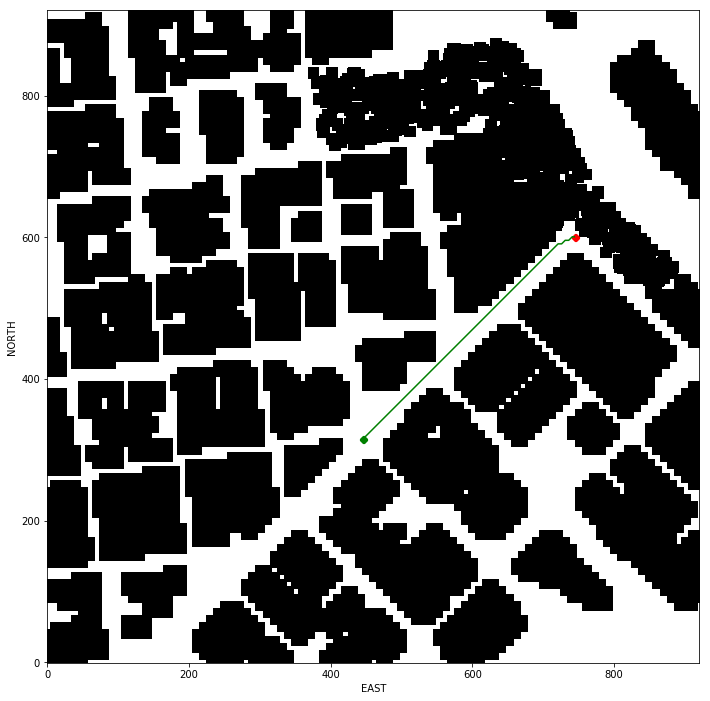

no timeout, continue
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 0, 5, 0]
waypoint transition
target position [0, 1, 5, 0]
waypoint transition
target position [55, 56, 5, 0]
waypoint transition
target position [110, 111, 5, 0]
waypoint transition
target position [165, 166, 5, 0]
waypoint transition
target position [220, 221, 5, 0]
waypoint transition
target position [275, 276, 5, 0]
waypoint transition
target position [275, 281, 5, 0]
waypoint transition
target position [280, 286, 5, 0]
waypoint transition
target position [280, 291, 5, 0]
waypoint transition
target position [285, 296, 5, 0]
waypoint transition
target position [285, 299, 5, 0]
landing transition
disarm transition
manual transition
Closing connection ...
1. is_timeout:False, state:States.MANUAL, connected:False, in_mission:False, armed:False, t:71.73093962669373


In [12]:
main(local_goal = (285, 300))

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.397   37.792    0.   ], position [-1.224e+02  3.780e+01 -3.700e-02], local position [2.850e+02 2.994e+02 3.733e-02]
North offset = -316, east offset = -445
Grid Start:  (603, 740)
Goal is set to (486, 182) with the parameter
Grid Start and Goal:  (603, 740) (486, 182)
#Nodes:1024, #Actions:7111, Cost:23.49, Currenct Node:(622, 736), Time:0.45
#Nodes:2048, #Actions:14130, Cost:175.71, Currenct Node:(483, 616), Time:0.84
#Nodes:4096, #Actions:28879, Cost:442.33, Currenct Node:(482, 359), Time:1.64
#Nodes:8192, #Actions:57140, Cost:402.69, Currenct Node:(422, 424), Time:3.02
Found a path.
#Nodes:12437, #Actions:84248, Cost:714.87, Currenct Node:(486, 182), Time:5.41
Path length: 133  cost: 714.872149726142
Pruned Path length:  25


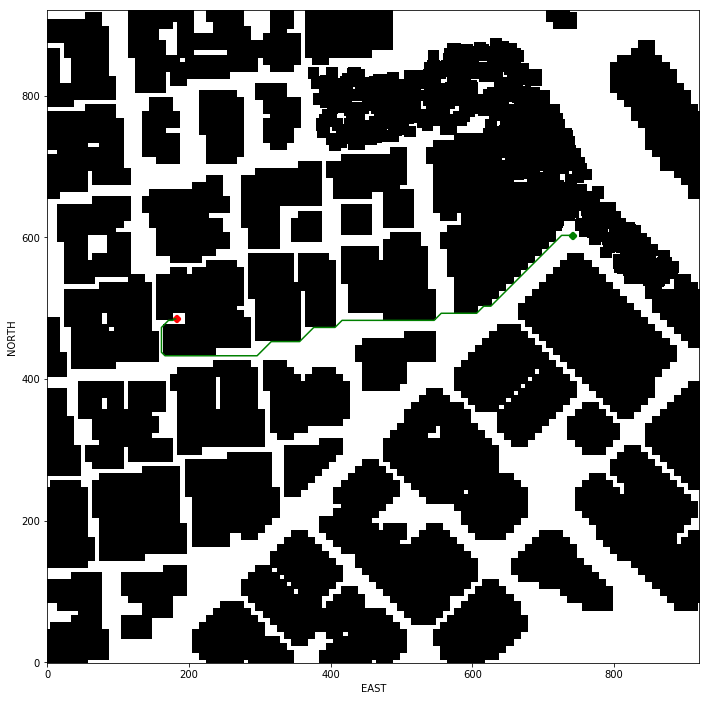

no timeout, continue
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [287, 295, 5, 0]
waypoint transition
target position [287, 281, 5, 0]
waypoint transition
target position [232, 226, 5, 0]
waypoint transition
target position [187, 181, 5, 0]
waypoint transition
target position [187, 171, 5, 0]
waypoint transition
target position [177, 161, 5, 0]
waypoint transition
target position [177, 111, 5, 0]
waypoint transition
target position [167, 101, 5, 0]
waypoint transition
target position [167, 46, 5, 0]
waypoint transition
target position [167, -9, 5, 0]
waypoint transition
target position [167, -29, 5, 0]
waypoint transition
target position [157, -39, 5, 0]
waypoint transition
target position [157, -69, 5, 0]
waypoint transition
target position [137, -89, 5, 0]
waypoint transition
target position [137, -129, 5, 0]
waypoint transition
target position [117, -149, 5, 0]
waypoint transition
target position [117, -204, 5, 0]
waypoint transition
tar

In [13]:
main(global_goal = (-122.400424, 37.794026))

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.397   37.792    0.   ], position [-1.224e+02  3.779e+01  8.000e-03], local position [ 1.694e+02 -2.635e+02 -8.273e-03]
North offset = -316, east offset = -445
Grid Start:  (483, 183)
Goal is set to (750, 800) with the parameter
Grid Start and Goal:  (483, 183) (750, 800)
#Nodes:1024, #Actions:5422, Cost:244.20, Currenct Node:(597, 282), Time:0.34
#Nodes:2048, #Actions:11900, Cost:197.21, Currenct Node:(433, 297), Time:0.88
#Nodes:4096, #Actions:25186, Cost:323.78, Currenct Node:(622, 338), Time:2.15
#Nodes:8192, #Actions:52616, Cost:369.20, Currenct Node:(477, 439), Time:4.62
#Nodes:16384, #Actions:106801, Cost:323.78, Currenct Node:(688, 254), Time:7.54
#Nodes:32768, #Actions:215620, Cost:343.43, Currenct Node:(787, 128), Time:15.62
Found a path.
#Nodes:34172, #Actions:225104, Cost:1031.58, Currenct Node:(750, 800), Time:16.14
Path length: 184  cost: 1031.5777772109152
P

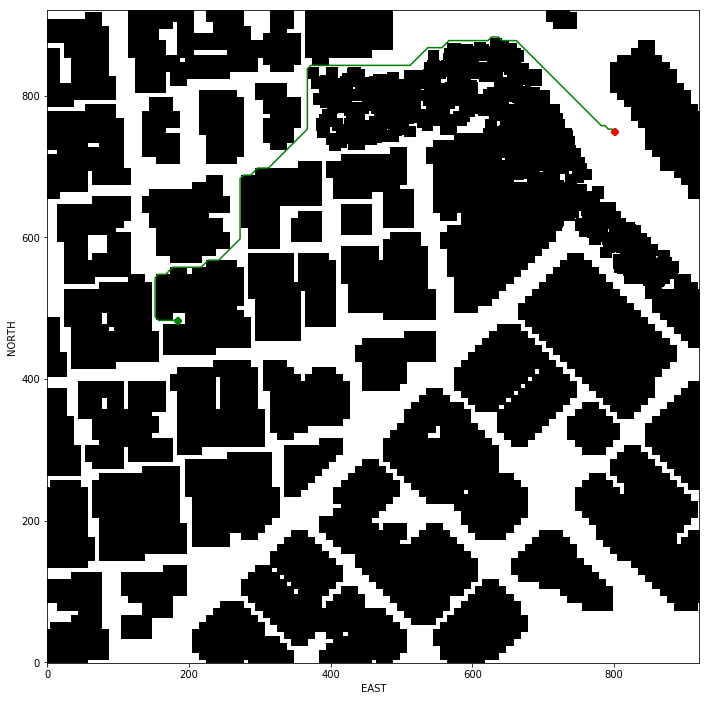

no timeout, continue
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [167, -262, 5, 0]
waypoint transition
target position [167, -288, 5, 0]
waypoint transition
target position [172, -293, 5, 0]
waypoint transition
target position [227, -293, 5, 0]
waypoint transition
target position [232, -288, 5, 0]
waypoint transition
target position [232, -278, 5, 0]
waypoint transition
target position [242, -268, 5, 0]
waypoint transition
target position [242, -228, 5, 0]
waypoint transition
target position [252, -218, 5, 0]
waypoint transition
target position [252, -203, 5, 0]
waypoint transition
target position [282, -173, 5, 0]
waypoint transition
target position [337, -173, 5, 0]
waypoint transition
target position [367, -173, 5, 0]
waypoint transition
target position [372, -168, 5, 0]
waypoint transition
target position [372, -158, 5, 0]
waypoint transition
target position [382, -148, 5, 0]
waypoint transition
target position [382, -133, 5, 0]
waypoin

In [14]:
main(grid_goal = (750, 800))

main
Logs/TLog.txt
Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.397   37.792    0.   ], position [-1.224e+02  3.780e+01  8.500e-02], local position [ 4.349e+02  3.546e+02 -8.474e-02]
North offset = -316, east offset = -445
Grid Start:  (753, 793)
change [ 0.263  0.287 -0.31 ]
Goal Global:  (-122.3948273748923, 37.79535073494847, -3.1017610389203067)
Goal Local:  [319.956 229.139   3.102]
change [ 0.261  0.443 -0.093]
Goal Global:  (-122.3948462311689, 37.79691519250227, -0.9342860136020348)
Goal Local:  [493.522 226.355   0.934]
change [-0.113  0.353 -0.075]
Goal Global:  (-122.39858157128835, 37.796007435324206, -0.7454343288466336)
Goal Local:  [ 390.684 -101.856    0.745]
Grid Start and Goal:  (753, 793) (707, 343)
#Nodes:1024, #Actions:7791, Cost:34.28, Currenct Node:(778, 772), Time:0.85
#Nodes:2048, #Actions:15668, Cost:31.41, Currenct Node:(784, 794), Time:1.52
#Nodes:4096, #Actions:31100, Cost:147.84, Currenct Node:(854, 689),

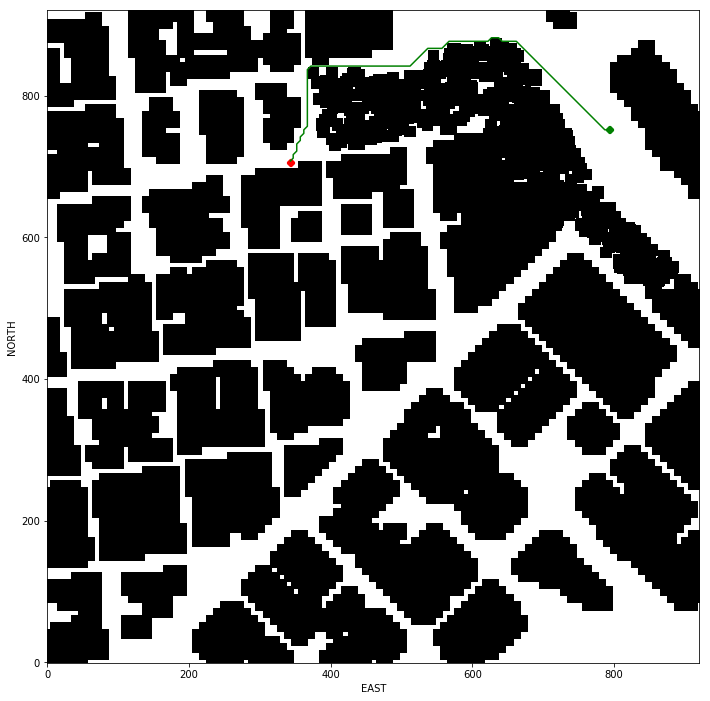

no timeout, continue
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [437, 348, 5, 0]
waypoint transition
target position [436, 347, 5, 0]
waypoint transition
target position [436, 342, 5, 0]
waypoint transition
target position [491, 287, 5, 0]
waypoint transition
target position [546, 232, 5, 0]
waypoint transition
target position [561, 217, 5, 0]
waypoint transition
target position [561, 197, 5, 0]
waypoint transition
target position [566, 192, 5, 0]
waypoint transition
target position [566, 182, 5, 0]
waypoint transition
target position [561, 177, 5, 0]
waypoint transition
target position [561, 122, 5, 0]
waypoint transition
target position [551, 112, 5, 0]
waypoint transition
target position [551, 92, 5, 0]
waypoint transition
target position [526, 67, 5, 0]
waypoint transition
target position [526, 12, 5, 0]
waypoint transition
target position [526, -43, 5, 0]
waypoint transition
target position [526, -73, 5, 0]
waypoint transition
target 

In [15]:
main()